# AWS A/B testing, traffic shifting and autoscaling

create an endpoint with multiple variants, splitting the traffic between them. after testing and reviewing the endpoint performance metrics, shift the traffic to one variant and configure it to autoscale.



Install and import the required modules.

In [2]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!conda install -q -y pytorch==1.6.0 -c pytorch
!pip install --disable-pip-version-check -q transformers==3.5.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sparkmagic 0.20.4 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda-client==1.7.2=py37_0
  - defaults/noarch::anaconda-project==0.8.4=py_0
  - defaults/linux-64::bokeh==1.4.0=py37_0
  - defaults/noarch::dask==2.11.0=py_0
  - defaults/linux-64::distributed==2.11.0=py37_0
  - defaults/linux-64::spyder==4.0.1=py37_0
  - defaults/linux-64::watchdog==0.10.2=py37_0
done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pytorch==1.6.0


The following packages 

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
import boto3
import sagemaker
import pandas as pd
import botocore

config = botocore.config.Config(user_agent_extra='dlai-pds/c3/w2')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

cw = boto3.client(service_name='cloudwatch', 
                  config=config)

autoscale = boto3.client(service_name="application-autoscaling", 
                         config=config)

<a name='c3w2-1.'></a>
# 1. Create an endpoint with multiple variants

Two models trained to analyze customer feedback and classify the messages into positive (1), neutral (0), and negative (-1) sentiments are saved in the following S3 bucket paths. These tar.gz files contain the trained model artifacts.

In [5]:
model_a_s3_uri = 's3://dlai-practical-data-science/models/ab/variant_a/model.tar.gz'
model_b_s3_uri = 's3://dlai-practical-data-science/models/ab/variant_b/model.tar.gz'

Deploy an endpoint splitting the traffic between these two models 50/50 to perform A/B Testing. 
Create an `Endpoint configuration` with multiple model variants.

### 1.1. Construct Docker Image URI

create the models in Amazon SageMaker, which retrieves the URI for the pre-built SageMaker Docker image stored in Amazon Elastic Container Registry (ECR). 

Set the instance type.

In [6]:
inference_instance_type = 'ml.m5.large'

Create an ECR URI using the 'PyTorch' framework. 

In [8]:
inference_image_uri = sagemaker.image_uris.retrieve(
    framework='pytorch',
    version='1.6.0',
    instance_type=inference_instance_type,
    region=region,
    py_version='py3',
    image_scope='inference'
)
print(inference_image_uri)

763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.6.0-cpu-py3


### 1.2. Create Amazon SageMaker Models



Set the model names.

In [9]:
import time
from pprint import pprint

timestamp = int(time.time())

model_name_a = '{}-{}'.format('a', timestamp)
model_name_b = '{}-{}'.format('b', timestamp)

check if the model already exists in Amazon SageMaker.

In [10]:
def check_model_existence(model_name):
    for model in sm.list_models()['Models']:
        if model_name == model['ModelName']:
            return True
    return False



Create an Amazon SageMaker Model based on the "model_a_s3_uri" data.


In [11]:
if not check_model_existence(model_name_a):
    model_a = sm.create_model(
        ModelName=model_name_a,
        ExecutionRoleArn=role,
        PrimaryContainer={
            'ModelDataUrl': model_a_s3_uri, 
            'Image': inference_image_uri 
        }
    )
    pprint(model_a)
else:
    print("Model {} already exists".format(model_name_a))

{'ModelArn': 'arn:aws:sagemaker:us-east-1:513085621326:model/a-1690383671',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '74',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Wed, 26 Jul 2023 15:02:44 GMT',
                                      'x-amzn-requestid': 'da75a0a7-f9b2-4557-b8e9-ba185165d79d'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'da75a0a7-f9b2-4557-b8e9-ba185165d79d',
                      'RetryAttempts': 0}}




Create an Amazon SageMaker Model based on the "model_b_s3_uri" data.


In [18]:
if not check_model_existence(model_name_b):
    model_b = sm.create_model(
        ModelName=model_name_b, 
        ExecutionRoleArn=role, 
        PrimaryContainer={
            'ModelDataUrl': model_b_s3_uri, 
            'Image': inference_image_uri
        }
    )
    pprint(model_b)
else:
    print("Model {} already exists".format(model_name_b))

Model b-1690383671 already exists


### 1.3. Set up Amazon SageMaker production variants

A production variant is a packaged SageMaker Model combined with the configuration. 



Create an Amazon SageMaker production variant for the SageMaker Model with the "model_name_a".


In [15]:
from sagemaker.session import production_variant

variantA = production_variant(
    model_name=model_name_a, 
    instance_type=inference_instance_type,
    initial_weight=50,
    initial_instance_count=1,
    variant_name='VariantA',
)
print(variantA)

{'ModelName': 'a-1690383671', 'InstanceType': 'ml.m5.large', 'InitialInstanceCount': 1, 'VariantName': 'VariantA', 'InitialVariantWeight': 50}


Create an Amazon SageMaker production variant for the SageMaker Model with the "model_name_b".


In [17]:
variantB = production_variant(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    model_name=model_name_b, # Replace all None
    instance_type=inference_instance_type, # Replace all None
    initial_weight=50, # Replace all None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    initial_instance_count=1,
    variant_name='VariantB'
)
print(variantB)

{'ModelName': 'b-1690383671', 'InstanceType': 'ml.m5.large', 'InitialInstanceCount': 1, 'VariantName': 'VariantB', 'InitialVariantWeight': 50}


### 1.4. Configure and create the endpoint

check if the endpoint configuration and endpoint itself already exist in Amazon SageMaker.

In [19]:
def check_endpoint_config_existence(endpoint_config_name):
    for endpoint_config in sm.list_endpoint_configs()['EndpointConfigs']:
        if endpoint_config_name == endpoint_config['EndpointConfigName']:
            return True
    return False

def check_endpoint_existence(endpoint_name):
    for endpoint in sm.list_endpoints()['Endpoints']:
        if endpoint_name == endpoint['EndpointName']:
            return True
    return False

Create the endpoint configuration. pointing to the two production variants.

In [20]:
endpoint_config_name = '{}-{}'.format('ab', timestamp)

if not check_endpoint_config_existence(endpoint_config_name):
    endpoint_config = sm.create_endpoint_config(
        EndpointConfigName=endpoint_config_name, 
        ProductionVariants=[variantA, variantB]
    )
    pprint(endpoint_config)
else:
    print("Endpoint configuration {} already exists".format(endpoint_config_name))

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:513085621326:endpoint-config/ab-1690383671',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '94',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Wed, 26 Jul 2023 15:08:58 GMT',
                                      'x-amzn-requestid': 'f3b25f36-905d-4ef6-8a69-2533cc2bf8d9'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'f3b25f36-905d-4ef6-8a69-2533cc2bf8d9',
                      'RetryAttempts': 0}}


Construct the endpoint name.

In [21]:
model_ab_endpoint_name = '{}-{}'.format('ab', timestamp)
print('Endpoint name: {}'.format(model_ab_endpoint_name))

Endpoint name: ab-1690383671


Create an endpoint with the endpoint name and configuration defined above.

In [22]:
if not check_endpoint_existence(model_ab_endpoint_name):
    endpoint_response = sm.create_endpoint(
        EndpointName=model_ab_endpoint_name, 
        EndpointConfigName=endpoint_config_name 
    )
    print('Creating endpoint {}'.format(model_ab_endpoint_name))
    pprint(endpoint_response)
else:
    print("Endpoint {} already exists".format(model_ab_endpoint_name))

Creating endpoint ab-1690383671
{'EndpointArn': 'arn:aws:sagemaker:us-east-1:513085621326:endpoint/ab-1690383671',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '81',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Wed, 26 Jul 2023 15:11:13 GMT',
                                      'x-amzn-requestid': '72d5418f-4348-4638-86aa-c3d496381df0'},
                      'HTTPStatusCode': 200,
                      'RequestId': '72d5418f-4348-4638-86aa-c3d496381df0',
                      'RetryAttempts': 0}}


Review the created endpoint configuration in the AWS console.



In [23]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpointConfig/{}">REST Endpoint configuration</a></b>'.format(
            region, endpoint_config_name
        )
    )
)

Review the created endpoint in the AWS console.


In [24]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST endpoint</a></b>'.format(region, model_ab_endpoint_name)))

In [25]:
%%time

waiter = sm.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=model_ab_endpoint_name)

CPU times: user 47.8 ms, sys: 7.63 ms, total: 55.5 ms
Wall time: 2min 30s


<a name='c3w2-2.'></a>
# 2. Test model

<a name='c3w2-2.1.'></a>
### 2.1. Test the model on a few sample strings

Here, you will pass sample strings of text to the endpoint in order to see the sentiment. You are given one example of each, however, feel free to play around and change the strings yourself!

Create an Amazon SageMaker Predictor based on the deployed endpoint.

In [27]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONLinesSerializer
from sagemaker.deserializers import JSONLinesDeserializer

inputs = [
    {"features": ["I love this product!"]},
    {"features": ["OK, but not great."]},
    {"features": ["This is not the right product."]},
]

predictor = Predictor(
    endpoint_name=model_ab_endpoint_name, 
    serializer=JSONLinesSerializer(), 
    deserializer=JSONLinesDeserializer(), 
    sagemaker_session=sess
)

predicted_classes = predictor.predict(inputs)

for predicted_class in predicted_classes:
    print("Predicted class {} with probability {}".format(predicted_class['predicted_label'], predicted_class['probability']))

Predicted class 1 with probability 0.9605445861816406
Predicted class 0 with probability 0.5798221230506897
Predicted class -1 with probability 0.7667604684829712


### 2.2. Generate traffic and review the endpoint performance metrics


Create a function to extract the results from CloudWatch and plot them.

In [28]:
def plot_endpoint_metrics_for_variants(endpoint_name, 
                                       namespace_name, 
                                       metric_name, 
                                       variant_names, 
                                       start_time, 
                                       end_time):
    
    try:
        joint_variant_metrics = None

        for variant_name in variant_names:
            metrics = cw.get_metric_statistics( # extracts the results in a dictionary format
                Namespace=namespace_name, # the namespace of the metric, e.g. "AWS/SageMaker"
                MetricName=metric_name, # the name of the metric, e.g. "CPUUtilization"
                StartTime=start_time, # the time stamp that determines the first data point to return
                EndTime=end_time, # the time stamp that determines the last data point to return
                Period=60, # the granularity, in seconds, of the returned data points
                Statistics=["Sum"], # the metric statistics
                Dimensions=[ # dimensions, as CloudWatch treats each unique combination of dimensions as a separate metric
                    {"Name": "EndpointName", "Value": endpoint_name}, 
                    {"Name": "VariantName", "Value": variant_name}
                ],
            )
            
            if metrics["Datapoints"]: # access the results from the distionary using the key "Datapoints"
                df_metrics = pd.DataFrame(metrics["Datapoints"]) \
                    .sort_values("Timestamp") \
                    .set_index("Timestamp") \
                    .drop("Unit", axis=1) \
                    .rename(columns={"Sum": variant_name}) # rename the column with the metric results as a variant_name
                
                if joint_variant_metrics is None:
                    joint_variant_metrics = df_metrics
                else:
                    joint_variant_metrics = joint_variant_metrics.join(df_metrics, how="outer")
        
        joint_variant_metrics.plot(title=metric_name)
    except:
        pass

Establish wide enough time bounds to show all the charts 

In [29]:
from datetime import datetime, timedelta

start_time = datetime.now() - timedelta(minutes=30)
end_time = datetime.now() + timedelta(minutes=30)

print('Start Time: {}'.format(start_time))
print('End Time: {}'.format(end_time))

Start Time: 2023-07-26 14:47:33.504016
End Time: 2023-07-26 15:47:33.504070


Set the list of the the variant names.

In [30]:
variant_names = [variantA["VariantName"], variantB["VariantName"]]

print(variant_names)

['VariantA', 'VariantB']


Run some predictions and view the metrics for each variant.


In [31]:
%%time

for i in range(0, 100):
    predicted_classes = predictor.predict(inputs)

CPU times: user 264 ms, sys: 20.5 ms, total: 284 ms
Wall time: 1min 26s


In [32]:
time.sleep(30) # Sleep to accomodate a slight delay in metrics gathering

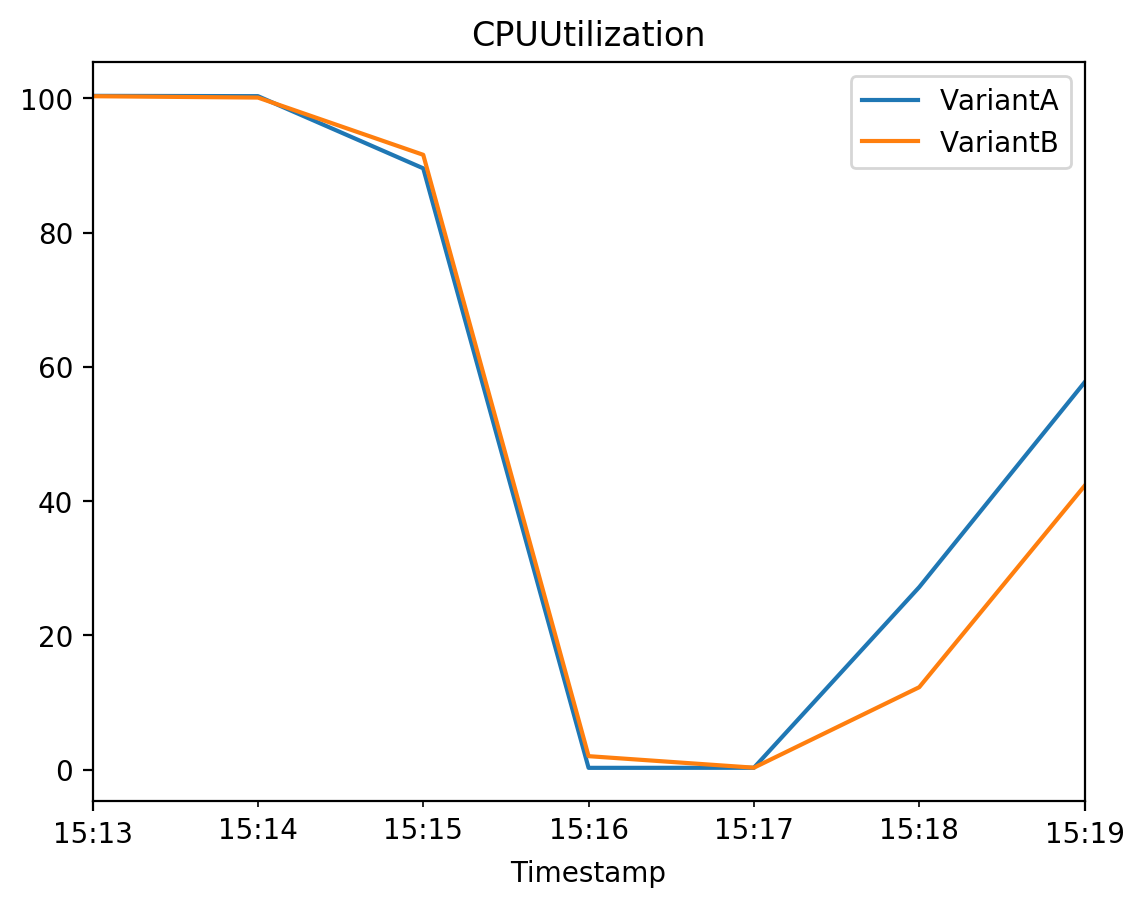

In [33]:
# CPUUtilization
# The sum of each individual CPU core's utilization. 
# The CPU utilization of each core can range between 0 and 100. For example, if there are four CPUs, CPUUtilization can range from 0% to 400%.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="/aws/sagemaker/Endpoints", 
    metric_name="CPUUtilization",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

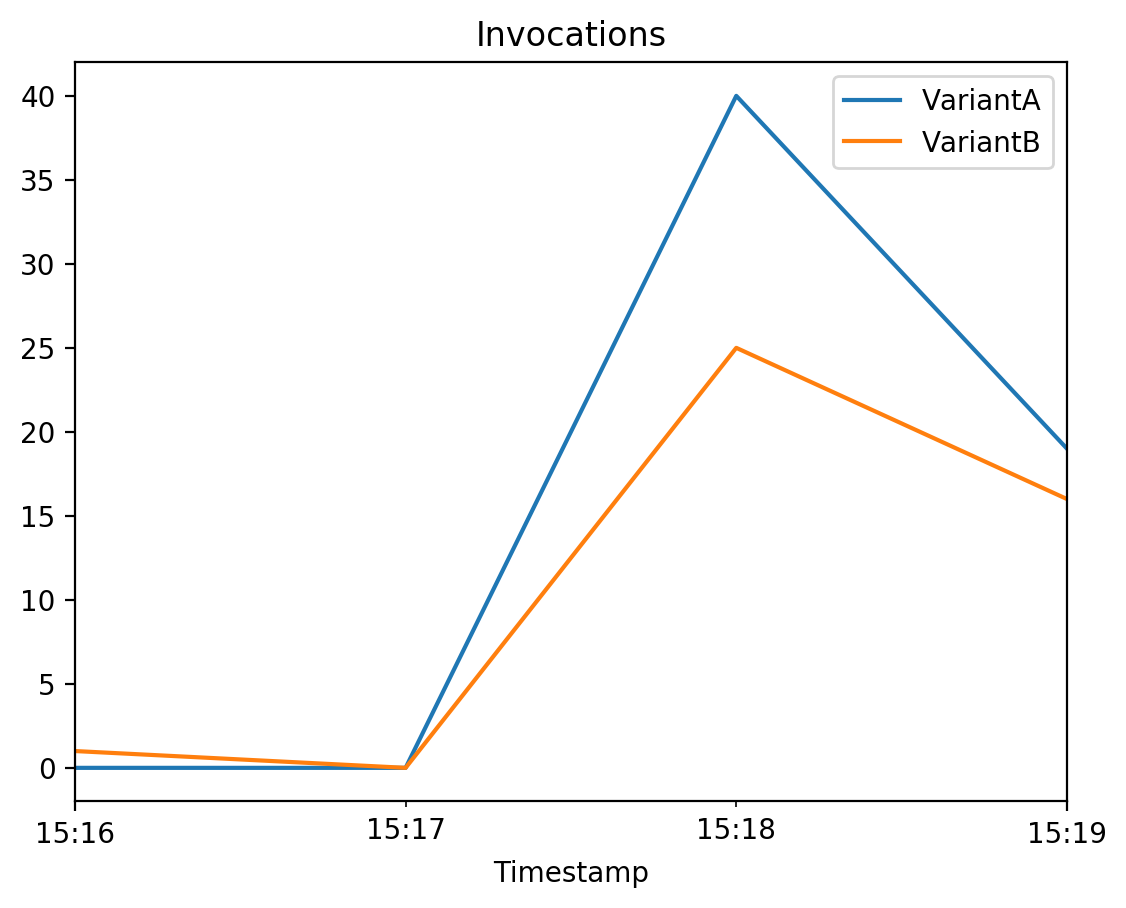

In [34]:
# Invocations
# The number of requests sent to a model endpoint.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="Invocations",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

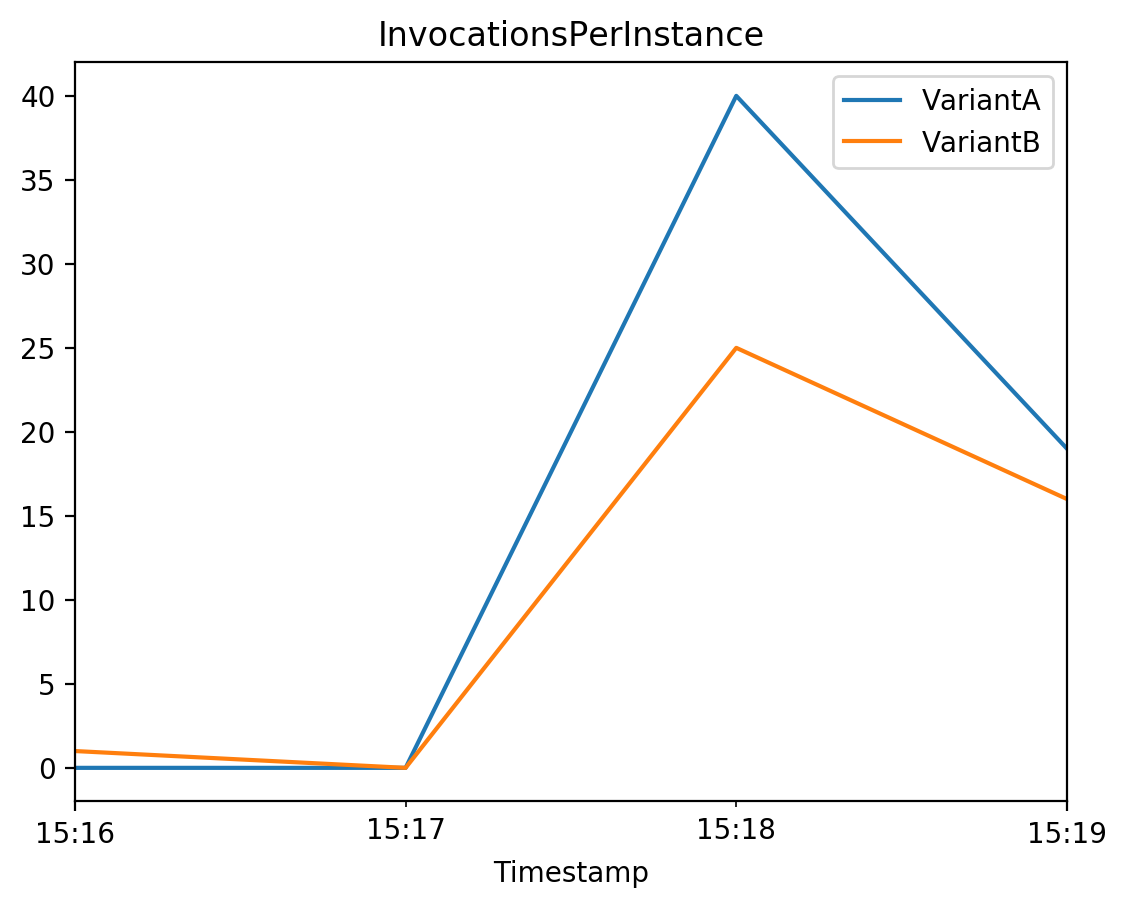

In [35]:
# InvocationsPerInstance
# The number of invocations sent to a model, normalized by InstanceCount in each production variant.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="InvocationsPerInstance",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

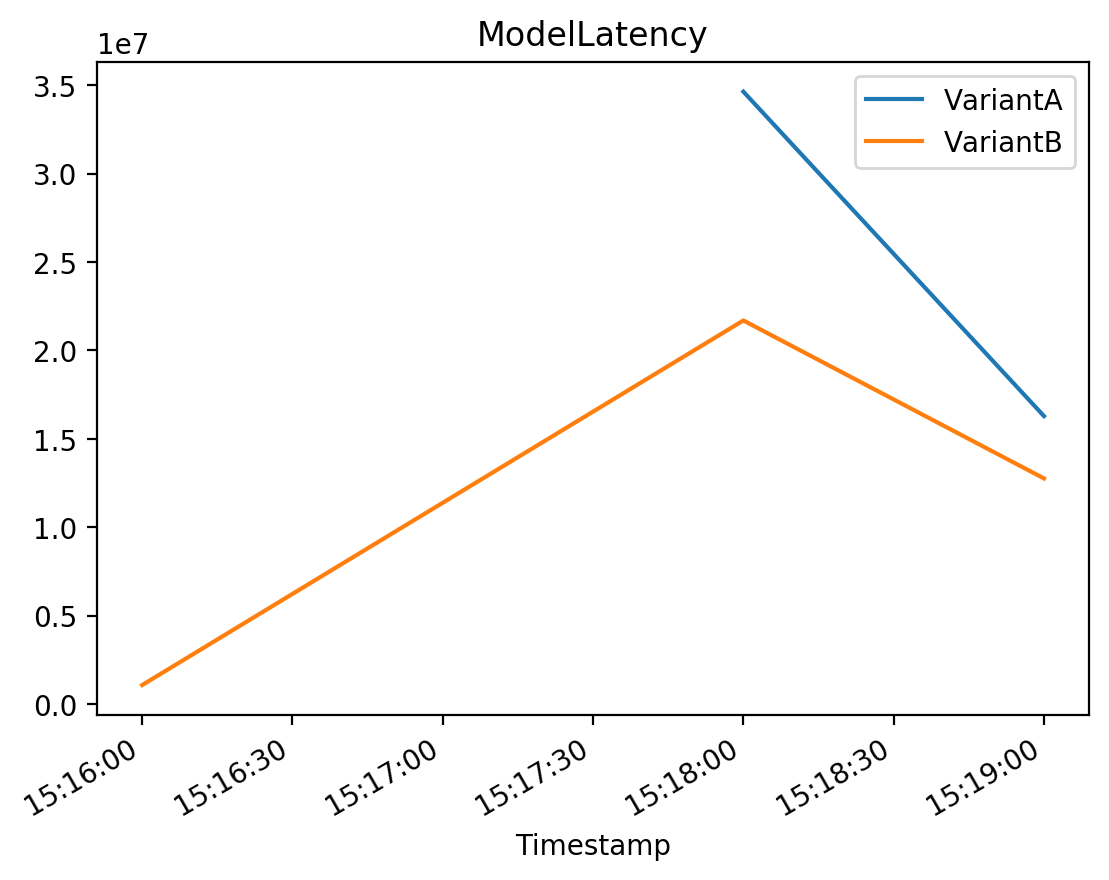

In [36]:
# ModelLatency
# The interval of time taken by a model to respond as viewed from SageMaker (in microseconds).
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="ModelLatency",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

# 3. Shift the traffic to one variant and review the endpoint performance metrics

the winning model would need to be chosen. 
The decision would be made based on the endpoint performance metrics and some other business related evaluations. 
Assume that the winning model is in the Variant B and shift all traffic to it. 

Create a list with the updated endpoint weights.


In [37]:
updated_endpoint_config = [
    {
        "VariantName": variantA["VariantName"],
        "DesiredWeight": 0,
    },
    {
        "VariantName": variantB["VariantName"],
        "DesiredWeight": 100,
    },
]

Update variant weights in the configuration of the existing endpoint.



In [38]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=model_ab_endpoint_name,
    DesiredWeightsAndCapacities=updated_endpoint_config 
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:513085621326:endpoint/ab-1690383671',
 'ResponseMetadata': {'RequestId': 'f7bc0d49-7715-49d6-88f9-7ab2b9ccf2a7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f7bc0d49-7715-49d6-88f9-7ab2b9ccf2a7',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '81',
   'date': 'Wed, 26 Jul 2023 15:22:15 GMT'},
  'RetryAttempts': 0}}

Review the endpoint in the AWS console.


In [39]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST endpoint</a></b>'.format(region, model_ab_endpoint_name)))

In [40]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

In [41]:
%%time

for i in range(0, 100):
    predicted_classes = predictor.predict(inputs)

CPU times: user 255 ms, sys: 22.4 ms, total: 278 ms
Wall time: 1min 28s


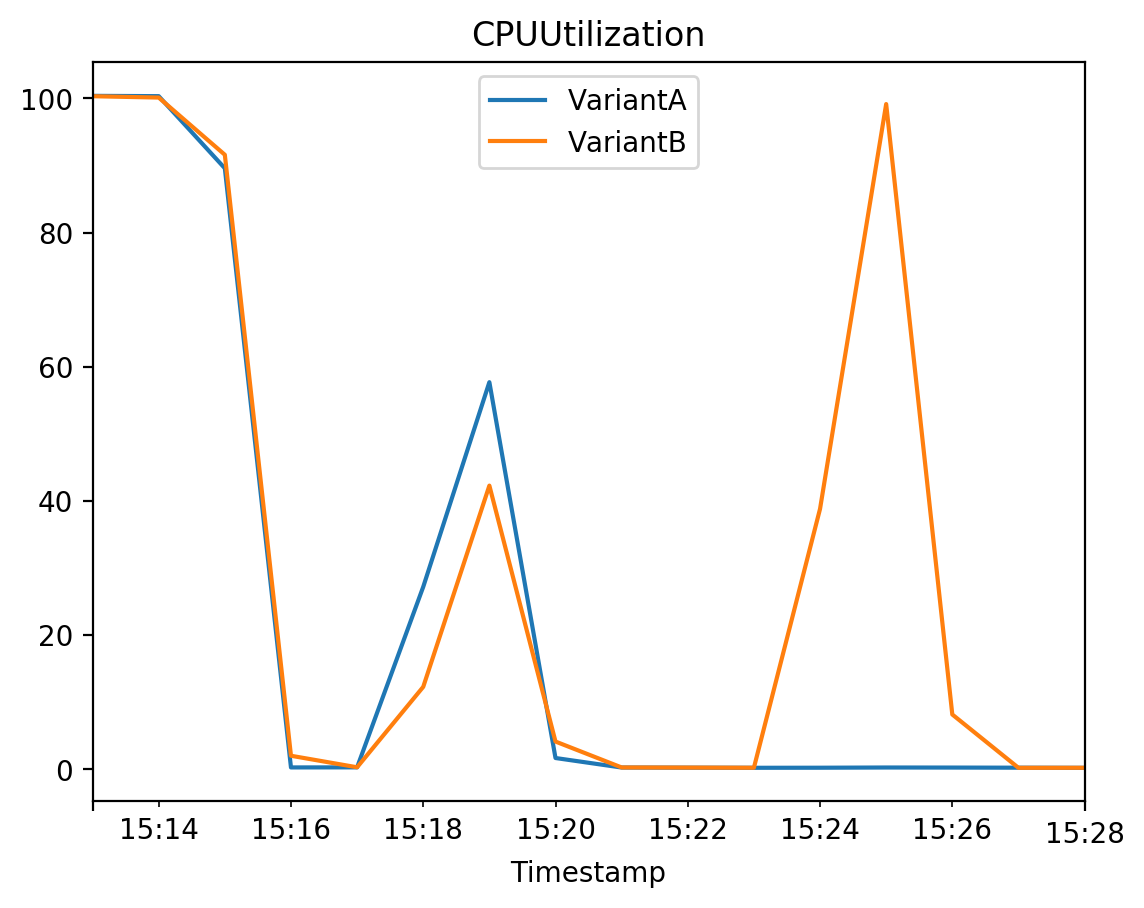

In [42]:
# CPUUtilization
# The sum of each individual CPU core's utilization. 
# The CPU utilization of each core can range between 0 and 100. For example, if there are four CPUs, CPUUtilization can range from 0% to 400%.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="/aws/sagemaker/Endpoints",
    metric_name="CPUUtilization",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

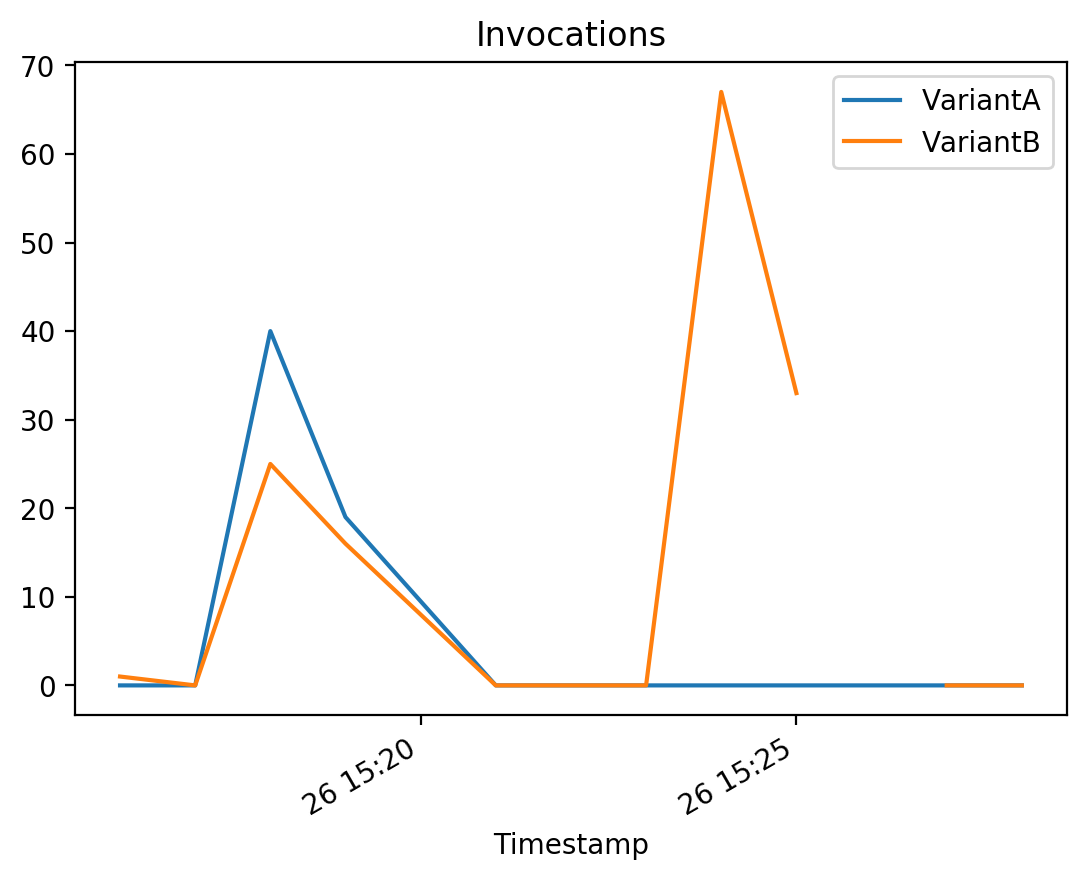

In [43]:
# Invocations
# The number of requests sent to a model endpoint.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="Invocations",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

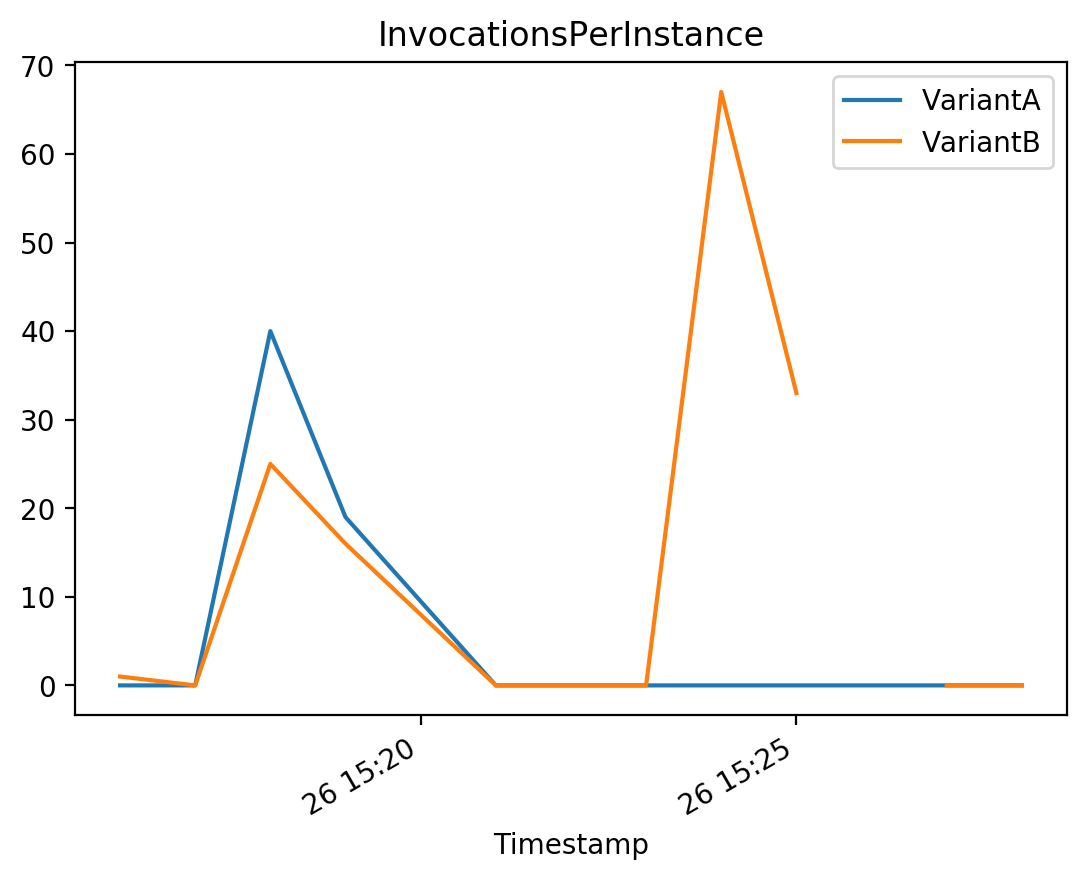

In [44]:
# InvocationsPerInstance
# The number of invocations sent to a model, normalized by InstanceCount in each production variant.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="InvocationsPerInstance",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

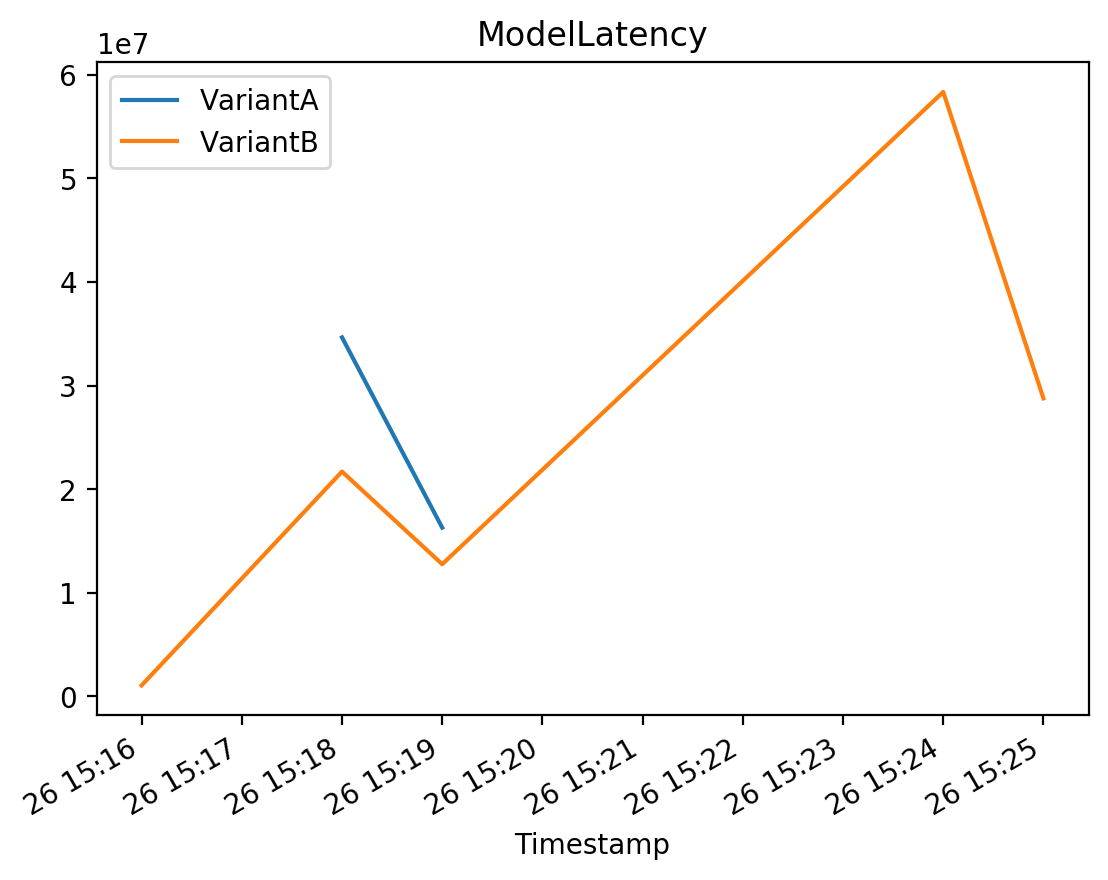

In [45]:
# ModelLatency
# The interval of time taken by a model to respond as viewed from SageMaker (in microseconds).
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="ModelLatency",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

# 4. Configure one variant to autoscale

configure Variant B to autoscale. 


In [46]:
autoscale.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId="endpoint/" + model_ab_endpoint_name + "/variant/VariantB",
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=1,
    MaxCapacity=2,
    RoleARN=role,
    SuspendedState={
        "DynamicScalingInSuspended": False,
        "DynamicScalingOutSuspended": False,
        "ScheduledScalingSuspended": False,
    },
)

{'ScalableTargetARN': 'arn:aws:application-autoscaling:us-east-1:513085621326:scalable-target/056mf9fb7de0d833416b97f452b32af1fb9e',
 'ResponseMetadata': {'RequestId': '11261d9a-4387-41aa-9cd6-12af4f75c16f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '11261d9a-4387-41aa-9cd6-12af4f75c16f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '131',
   'date': 'Wed, 26 Jul 2023 15:30:03 GMT'},
  'RetryAttempts': 0}}

In [47]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

In [48]:
autoscale.describe_scalable_targets(
    ServiceNamespace="sagemaker",
    MaxResults=100,
)

{'ScalableTargets': [{'ServiceNamespace': 'sagemaker',
   'ResourceId': 'endpoint/ab-1690383671/variant/VariantB',
   'ScalableDimension': 'sagemaker:variant:DesiredInstanceCount',
   'MinCapacity': 1,
   'MaxCapacity': 2,
   'RoleARN': 'arn:aws:iam::513085621326:role/aws-service-role/sagemaker.application-autoscaling.amazonaws.com/AWSServiceRoleForApplicationAutoScaling_SageMakerEndpoint',
   'CreationTime': datetime.datetime(2023, 7, 26, 15, 30, 3, 689000, tzinfo=tzlocal()),
   'SuspendedState': {'DynamicScalingInSuspended': False,
    'DynamicScalingOutSuspended': False,
    'ScheduledScalingSuspended': False},
   'ScalableTargetARN': 'arn:aws:application-autoscaling:us-east-1:513085621326:scalable-target/056mf9fb7de0d833416b97f452b32af1fb9e'}],
 'ResponseMetadata': {'RequestId': 'c225c08d-23d4-4cc6-83b7-3612847b796f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c225c08d-23d4-4cc6-83b7-3612847b796f',
   'content-type': 'application/x-amz-json-1.1',
   'content-le

Define and apply scaling policy using the "put_scaling_policy" function. 



In [49]:
autoscale.put_scaling_policy(
    PolicyName="bert-reviews-autoscale-policy",
    ServiceNamespace="sagemaker",
    ResourceId="endpoint/" + model_ab_endpoint_name + "/variant/VariantB",
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyType="TargetTrackingScaling",
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 2.0, # the number of invocations per ML instance you want to allow before triggering your scaling policy
        "PredefinedMetricSpecification": {
            "PredefinedMetricType": "SageMakerVariantInvocationsPerInstance", # scaling metric
        },
        "ScaleOutCooldown": 60, # wait time, in seconds, before beginning another scale out activity after last one completes
        "ScaleInCooldown": 300, # wait time, in seconds, before beginning another scale in activity after last one completes
    },
)

{'PolicyARN': 'arn:aws:autoscaling:us-east-1:513085621326:scalingPolicy:f9fb7de0-d833-416b-97f4-52b32af1fb9e:resource/sagemaker/endpoint/ab-1690383671/variant/VariantB:policyName/bert-reviews-autoscale-policy',
 'Alarms': [{'AlarmName': 'TargetTracking-endpoint/ab-1690383671/variant/VariantB-AlarmHigh-5a6b4ca0-1c50-47bb-b38d-ec7a1647ddce',
   'AlarmARN': 'arn:aws:cloudwatch:us-east-1:513085621326:alarm:TargetTracking-endpoint/ab-1690383671/variant/VariantB-AlarmHigh-5a6b4ca0-1c50-47bb-b38d-ec7a1647ddce'},
  {'AlarmName': 'TargetTracking-endpoint/ab-1690383671/variant/VariantB-AlarmLow-2e44a529-7624-4af1-9ffc-cffeb1d156ac',
   'AlarmARN': 'arn:aws:cloudwatch:us-east-1:513085621326:alarm:TargetTracking-endpoint/ab-1690383671/variant/VariantB-AlarmLow-2e44a529-7624-4af1-9ffc-cffeb1d156ac'}],
 'ResponseMetadata': {'RequestId': 'dc141f41-930f-4da4-a966-84a7653114e0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'dc141f41-930f-4da4-a966-84a7653114e0',
   'content-type': 'ap

In [50]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

Generate traffic again and review the endpoint in the AWS console.

In [51]:
%%time

for i in range(0, 100):
    predicted_classes = predictor.predict(inputs)

CPU times: user 259 ms, sys: 17.8 ms, total: 277 ms
Wall time: 1min 27s


Review the autoscaling:



In [52]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST endpoint</a></b>'.format(region, model_ab_endpoint_name)))
